# Learning rate selection

Notebook regarding the selection of the learning rate based on the validation accuracy
achieved on a subset of training.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
def LearningRateSelector(Table, metric, model, pipeline, task, 
                         sampling = 125, outer=1, show_plot = True, verbose = True):

    # check input parameters and extract better names for plot
    metric_list = [
        'accuracy_unbalanced', 'accuracy_weighted', 'precision_micro', 
        'precision_macro', 'precision_weighted', 'recall_micro', 'recall_macro',
        'recall_weighted', 'f1score_micro', 'f1score_macro', 'f1score_weighted',
        'rocauc_micro', 'rocauc_macro', 'rocauc_weighted', 'cohen_kappa', 'val_loss'
    ]
    model_dict = {
        'eegnet': 'egn', 'shallownet': 'shn', 'deepconvnet': 'dcn',
        'resnet': 'res', 'eegsym': 'egs', 'atcnet': 'atc', 'hybridnet': 'hyb',
        'fbcnet': 'fbc'
    }
    pipeline_dict = {'raw': 'raw', 'filt': 'flt', 'ica': 'ica', 'icasr': 'isr'}
    task_dict = {
        'eyes': 'eye',
        'alzheimer': 'alz',
        'parkinson': 'pds',
        'motorimagery': 'mmi',
        'sleep': 'slp',
        'psychosis': 'fep'
    }

    if metric in metric_list:
        metric_full = metric.replace('_', ' ').replace('1','1-') 
    elif metric in [i.replace('_', ' ').replace('1','1-') for i in metric_list]:
        metric_full = metric
        metric = metric.replace(' ', '_').replace('1-','1')
    else:
        raise ValueError('metric not supported')
    
    if model in list(model_dict.keys()):
        model_full = model
        model = model_dict[model]
    elif model in list(model_dict.values()):
        inv_dict = {v: k for k, v in model_dict.items()}
        model_full = inv_dict[model]
    else:
        raise ValueError('model not supported')

    if pipeline in list(pipeline_dict.keys()):
        pipeline_full = pipeline
        pipeline = pipeline_dict[model]
    elif pipeline in list(pipeline_dict.values()):
        inv_dict = {v: k for k, v in pipeline_dict.items()}
        pipeline_full = inv_dict[pipeline]
    else:
        raise ValueError('pipeline not supported')

    if task in list(task_dict.keys()):
        task_full = task
        task = task_dict[task]
    elif task in list(task_dict.values()):
        inv_dict = {v: k for k, v in task_dict.items()}
        task_full = inv_dict[task]
    else:
        raise ValueError('model not supported')

    if isinstance(outer, list):
        Ntrain = 5*len(outer)
        TableMini = Table.loc[(Table['model'] == model) & 
            (Table['sampling_rate'] == sampling) & 
            (Table['pipeline'] == pipeline) & 
            (Table['task'] == task ) & 
            (Table['outer_fold'].isin(outer))]
    else:
        Ntrain = 5
        TableMini = Table.loc[(Table['model'] == model) & 
            (Table['sampling_rate'] == sampling) & 
            (Table['pipeline'] == pipeline) & 
            (Table['task'] == task ) & 
            (Table['outer_fold'] == outer)]
    lr_list = TableMini['learning_rate'].unique().tolist()
    lr_list.sort(reverse=True)
    lr_tick = [ ]
    performances = [ ]
    for idx, lr in enumerate(lr_list):
        metrics = TableMini.loc[(TableMini['learning_rate'] == lr), metric]
        metrics = metrics.to_list()
        if len(metrics)==Ntrain:
            lr_tick.append("{:.1e}".format(lr))
            performances.append(metrics)
    
    perfmat = np.array(performances).T
    order = (-perfmat).argsort(axis=1)
    ranks = order.argsort(axis=1)
    ranksum = np.sum(ranks, axis=0)
    perfmedian = np.median(perfmat,axis=0)
    
    lr_dict = {
        'median': lr_list[np.argmax(perfmedian)],
        'rank': lr_list[np.argmin(ranksum)]
    }
    if verbose:
        print(' ')
        print(metric_full + ' median values')
        print(np.around(perfmedian, 4).tolist())
        print(' ')
        print(metric_full + ' max values')
        print(np.around( np.max(perfmat, axis = 0), 4).tolist())
        print(' ')
        print(metric_full + ' min values')
        print(np.around( np.min(perfmat, axis = 0), 4).tolist())
        print(' ')
        print(metric_full + ' rank values (lower values are better)')
        print(ranksum.tolist())
        print(' ')
        print(metric_full + ' full rank matrix')
        print(ranks)
    
    if show_plot:
        plt.figure( figsize = (15,8))
        plt.boxplot(performances, labels = lr_tick )
        plt.title(
            metric_full + ' -- model ' + model_full + \
            ', task ' + task_full + ', pipeline ' + pipeline_full + ' --',
            fontsize = 22
        )
        plt.ylabel(metric_full, fontsize=20)
        plt.yticks(fontsize=15)
        plt.xlabel('Learning Rate', fontsize=20)
        plt.xticks(fontsize=15)
        plt.show()

    return lr_dict

In [49]:
Table = pd.read_csv('ResultsTableLR.csv')
sampling = 125
outer = [1]
pipeline = 'isr'
metric = 'accuracy_weighted'

## EEGNet

In [50]:
model = 'egn'

 
accuracy weighted median values
[0.9398, 0.9097, 0.9136, 0.9238, 0.9123, 0.904]
 
accuracy weighted max values
[0.9827, 0.9725, 0.9802, 0.9667, 0.9738, 0.9718]
 
accuracy weighted min values
[0.8572, 0.8937, 0.8754, 0.8606, 0.8599, 0.8697]
 
accuracy weighted rank values (lower values are better)
[11, 13, 8, 16, 12, 15]
 
accuracy weighted full rank matrix
[[0 2 1 5 3 4]
 [0 4 2 1 3 5]
 [4 5 0 3 1 2]
 [5 2 4 3 0 1]
 [2 0 1 4 5 3]]


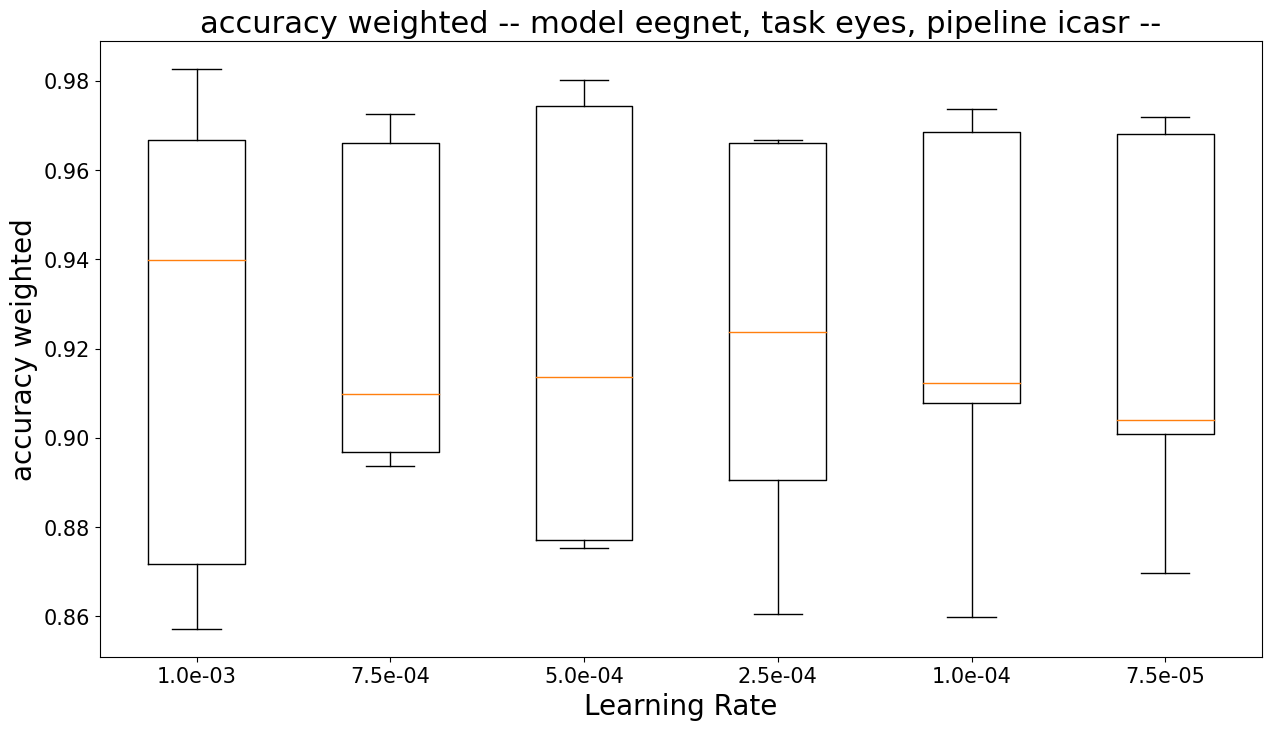

{'median': 0.001, 'rank': 0.0005}

In [51]:
task = 'eye'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'pds'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'alz'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'mmi'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'sleep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'fep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

## ShallowNet

In [ ]:
model = 'shn'

In [ ]:
task = 'eye'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'pds'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'alz'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'mmi'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'sleep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'fep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

## DeepConvNet

In [ ]:
model = 'dcn'

In [ ]:
task = 'eye'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'pds'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'alz'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'mmi'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'sleep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'fep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

## FBCNet

In [ ]:
model = 'fbc'

In [ ]:
task = 'eye'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'pds'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'alz'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'mmi'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'sleep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)

In [ ]:
task = 'fep'
LearningRateSelector(Table, metric, model, pipeline, task, sampling, show_plot = True)